In [36]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import random
import os
from PIL import Image
import numpy as np
import torch
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from torch.utils.data import random_split

In [37]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
import kagglehub

vggface2_path = kagglehub.dataset_download('hearfool/vggface2')
print(vggface2_path)

/root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


In [39]:
base_dir = "/root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1"
training_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "val")
train_batch_size = 64
train_number_epochs = 100
train_subset_size = 4000
val_subset_size = 1000
val_size = int(0.8 * val_subset_size)  # 80% for validation
test_size = val_subset_size - val_size  # 20% for test

In [40]:
# Data augmentation and preprocessing
transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [41]:
class SiameseNetworkDataset(Dataset):
    def __init__(self, image_paths, transform=None, should_invert=True):
        self.image_paths = image_paths
        self.transform = transform
        self.should_invert = should_invert

    def __getitem__(self, index):
        img0_path, img0_label = random.choice(self.image_paths)
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            img1_path, img1_label = random.choice([img for img in self.image_paths if img[1] == img0_label])
        else:
            img1_path, img1_label = random.choice([img for img in self.image_paths if img[1] != img0_label])

        img0 = Image.open(img0_path).convert("L")
        img1 = Image.open(img1_path).convert("L")

        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_label != img0_label)], dtype=np.float32))

    def __len__(self):
        return len(self.image_paths)


class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1), nn.Conv2d(1, 4, kernel_size=3), nn.ReLU(inplace=True), nn.BatchNorm2d(4),
            nn.ReflectionPad2d(1), nn.Conv2d(4, 8, kernel_size=3), nn.ReLU(inplace=True), nn.BatchNorm2d(8),
            nn.ReflectionPad2d(1), nn.Conv2d(8, 8, kernel_size=3), nn.ReLU(inplace=True), nn.BatchNorm2d(8)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8 * 100 * 100, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 500), nn.ReLU(inplace=True),
            nn.Linear(500, 128)  # Embedding dimension
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2


class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            label * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive


In [42]:
def train_model(net, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        net.train()
        epoch_loss = 0
        for i, data in enumerate(train_loader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            optimizer.zero_grad()
            output1, output2 = net(img0, img1)
            loss_contrastive = criterion(output1, output2, label)
            loss_contrastive.backward()
            optimizer.step()
            epoch_loss += loss_contrastive.item()

        train_losses.append(epoch_loss / len(train_loader))
        val_loss, val_acc = validate_model(net, val_loader, criterion)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    print(f"\nFinal Validation Loss: {val_losses[-1]:.4f}")
    print(f"Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
    return train_losses, val_losses, val_accuracies

def validate_model(net, val_loader, criterion):
    net.eval()
    val_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for data in val_loader:
            x0, x1, label = data
            x0, x1, label = x0.cuda(), x1.cuda(), label.cuda()
            output1, output2 = net(x0, x1)
            loss_contrastive = criterion(output1, output2, label)
            val_loss += loss_contrastive.item()

            euclidean_distance = F.pairwise_distance(output1, output2)
            prediction = (euclidean_distance > 1.0).float()
            correct += (prediction.cpu() == label.cpu()).sum().item()
            total += label.size(0)

    accuracy = (correct / total) * 100
    return val_loss / len(val_loader), accuracy


def plot_losses(train_losses, val_losses):
    epochs = np.arange(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss", color="blue")
    plt.plot(epochs, val_losses, label="Val Loss", color="orange")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_accuracy(val_accuracies):
    epochs = np.arange(1, len(val_accuracies) + 1)

    plt.figure(figsize=(8, 5))
    sns.set(style="whitegrid")
    sns.regplot(x=epochs, y=val_accuracies, lowess=True, scatter=True,
                label="Validation Accuracy",
                line_kws={"color": "green", "linewidth": 2},
                scatter_kws={"s": 50, "color": "green", "alpha": 0.6})

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Validation Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # plt.plot(epochs, val_accuracies, label="Val Accuracy", color="green")
    # plt.xlabel("Epochs")
    # plt.ylabel("Accuracy (%)")
    # plt.title("Validation Accuracy")
    # plt.legend()


def test_model(net, test_loader, criterion):
    net.eval()
    test_loss = 0
    correct, total = 0, 0

    with torch.no_grad():
        for data in test_loader:
            x0, x1, label = data
            x0, x1, label = x0.cuda(), x1.cuda(), label.cuda()
            output1, output2 = net(x0, x1)
            loss_contrastive = criterion(output1, output2, label)
            test_loss += loss_contrastive.item()

            euclidean_distance = F.pairwise_distance(output1, output2)
            prediction = (euclidean_distance > 1.0).float()
            correct += (prediction.cpu() == label.cpu()).sum().item()
            total += label.size(0)

    accuracy = (correct / total) * 100
    return test_loss / len(test_loader), accuracy


def load_dataset(directory, subset_size):
    folder_dataset = dset.ImageFolder(root=directory)
    subset_indices = random.sample(range(len(folder_dataset.imgs)), subset_size)
    subset_paths = [folder_dataset.imgs[i] for i in subset_indices]
    return SiameseNetworkDataset(image_paths=subset_paths, transform=transform, should_invert=False)

In [43]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

siamese_dataset_train = load_dataset(training_dir, train_subset_size)
train_dataloader = DataLoader(siamese_dataset_train, shuffle=True, num_workers=4, batch_size=train_batch_size)

full_val_dataset = load_dataset(validation_dir, val_subset_size)

# Split into validation and test sets
val_dataset, test_dataset = random_split(full_val_dataset, [val_size, test_size])

# Create dataloaders
val_dataloader = DataLoader(val_dataset, num_workers=4, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, num_workers=4, batch_size=1, shuffle=True)


train_losses, val_losses, val_accuracies = train_model( net, train_dataloader, val_dataloader, criterion, optimizer, train_number_epochs)

Epoch 1/100, Train Loss: 4.5038, Val Loss: 1.0452, Val Acc: 53.50%
Epoch 2/100, Train Loss: 1.0561, Val Loss: 1.0504, Val Acc: 50.12%
Epoch 3/100, Train Loss: 1.0242, Val Loss: 1.0420, Val Acc: 52.12%
Epoch 4/100, Train Loss: 1.0274, Val Loss: 1.0418, Val Acc: 52.00%
Epoch 5/100, Train Loss: 1.0201, Val Loss: 1.0713, Val Acc: 52.12%
Epoch 6/100, Train Loss: 1.0117, Val Loss: 0.9878, Val Acc: 55.88%
Epoch 7/100, Train Loss: 0.9695, Val Loss: 0.9928, Val Acc: 56.88%
Epoch 8/100, Train Loss: 0.9561, Val Loss: 0.9868, Val Acc: 60.12%
Epoch 9/100, Train Loss: 0.9316, Val Loss: 0.8973, Val Acc: 61.75%
Epoch 10/100, Train Loss: 0.9217, Val Loss: 0.9154, Val Acc: 64.62%
Epoch 11/100, Train Loss: 0.8893, Val Loss: 0.9096, Val Acc: 62.50%
Epoch 12/100, Train Loss: 0.8893, Val Loss: 0.9484, Val Acc: 61.50%
Epoch 13/100, Train Loss: 0.8468, Val Loss: 0.8933, Val Acc: 65.00%
Epoch 14/100, Train Loss: 0.8837, Val Loss: 0.8583, Val Acc: 65.00%
Epoch 15/100, Train Loss: 0.8208, Val Loss: 0.9552, Val A

In [50]:
# Save the trained model
torch.save(net.state_dict(), "siamese_model_v6.pth")
print("Model saved successfully!")

Model saved successfully!


In [45]:
test_loss, test_accuracy = test_model(net, test_dataloader, criterion)
print(f"\nFinal Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracy:.2f}%")


Final Test Loss: 0.7321
Final Test Accuracy: 71.00%


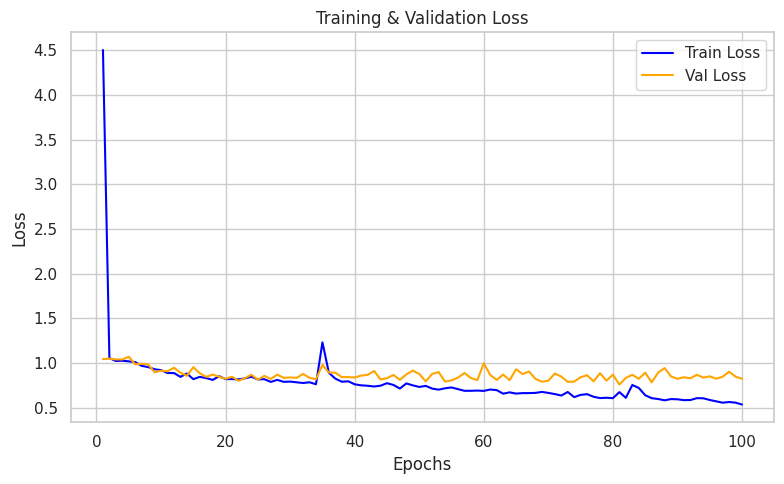

In [46]:
plot_losses(train_losses, val_losses)

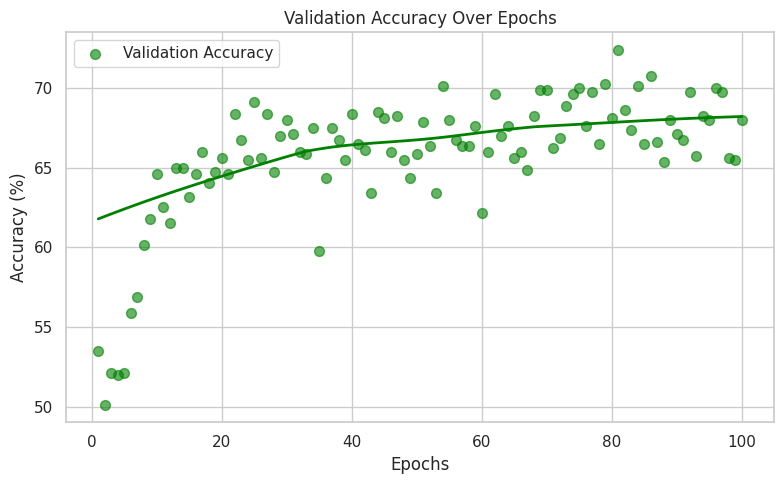

In [47]:
plot_accuracy(val_accuracies)

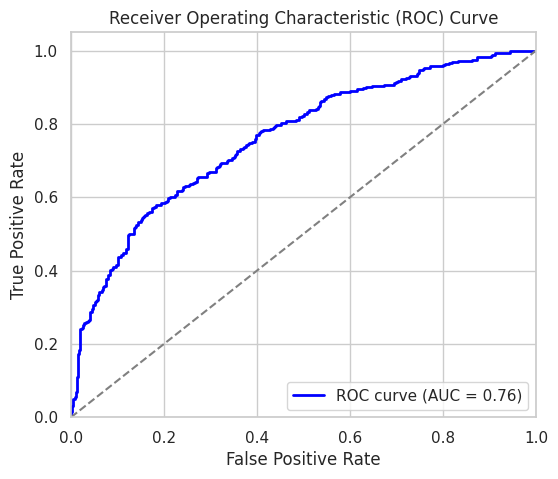

In [48]:
from sklearn.metrics import roc_curve, auc

def validate_model_roc(net, val_loader, criterion):
    net.eval()
    val_loss = 0
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data in val_loader:
            x0, x1, label = data
            x0, x1, label = x0.cuda(), x1.cuda(), label.cuda()

            output1, output2 = net(x0, x1)
            loss_contrastive = criterion(output1, output2, label)
            val_loss += loss_contrastive.item()

            # Compute Euclidean distance as the similarity score
            euclidean_distance = F.pairwise_distance(output1, output2)

            # Store labels and distances for ROC
            y_true.extend(label.cpu().numpy())  # Convert to numpy
            y_scores.extend(euclidean_distance.cpu().numpy())  # Convert to numpy

    return val_loss / len(val_loader), y_true, y_scores


def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random classifier line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()


# Validate and get ROC data
val_loss, y_true, y_scores = validate_model_roc(net, val_dataloader, criterion)

# Plot the ROC curve
plot_roc_curve(y_true, y_scores)


In [52]:
from google.colab import files  # if using Google Colab
files.download('siamese_model_v6.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>